# Datset: Pairwise approach

Get tracksters from a certain neighbourhood.

Neighbourhood:
- get links from ticlNtuplizer/graph
    - figure out how these links are formed

Graph:
- linked_inners
    - nodes linked to the given tracksters within its cone


In [1]:
import uproot
import torch
import random
import numpy as np

from reco.distance import euclidian_distance
from reco.matching import find_good_pairs
from reco.dataset import match_trackster_pairs, TracksterPairs
from reco.plotting import plot_tracksters
from reco.event import get_bary

import matplotlib.pyplot as plt

ds_name = "CloseByTwoPion"

# data_root = "data"
# raw_dir = f"/Users/ecuba/data/{ds_name}"

data_root = "/mnt/ceph/users/ecuba/processed"
raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

file_name = f"{raw_dir}/new_ntuples_15101852_455.root"

tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})
graph = uproot.open({file_name: "ticlNtuplizer/graph"})

In [2]:
eid = 10

# prepare distance points
vx = tracksters["vertices_x"].array()[eid]
vy = tracksters["vertices_y"].array()[eid]
vz = tracksters["vertices_z"].array()[eid]
ve = tracksters["vertices_energy"].array()[eid]
clouds = [np.array([vx[tid], vy[tid], vz[tid]]).T for tid in range(len(vx))]

## Candidate pairs

Compile a list of candidate pairs based on the CLUE3D graph and node distance.

Reject all nodes with above a distance threshold.

In [4]:
MAX_DISTANCE = 10   # cm

candidate_pairs = []
distances = []

inners_list = graph["linked_inners"].array()[eid]
for i, inners in enumerate(inners_list):
    for inner in inners:
        dst = euclidian_distance(clouds[i], clouds[inner])
        distances.append(dst)
        if dst <= MAX_DISTANCE:
            candidate_pairs.append((i, inner))
            
print("Candidate pairs:", len(candidate_pairs))

Candidate pairs: 62


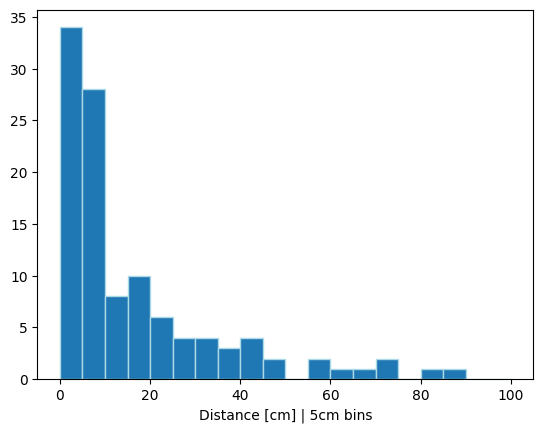

In [5]:
plt.hist(distances, bins=20, edgecolor="lightblue", range=(0, 100))
plt.xlabel("Distance [cm] | 5cm bins")
plt.show()

## Ground truth

In [6]:
gt_pairs = match_trackster_pairs(
    tracksters,
    simtracksters,
    associations,
    eid,
    distance_threshold=MAX_DISTANCE,
)
print("Ground truth pairs:", len(gt_pairs))

Ground truth pairs: 20


In [7]:
# sanity check
# all gold pairs are present in the candidate pairs

ab_pairs = set([(a, b) for a, b, _ in gt_pairs])
ba_pairs = set([(b, a) for a, b, _ in gt_pairs])
c_pairs = set(candidate_pairs)

matches = ab_pairs.union(ba_pairs).intersection(c_pairs)
not_matches = c_pairs - matches

# edges that are not the best but still correct
neutral = find_good_pairs(tracksters, associations, not_matches, eid)
positive = list(matches)
negative = random.sample(list(not_matches-neutral), k=len(matches))

print(f"positive: {len(positive)} negative: {len(not_matches)} negative selected: {len(set(negative))} neutral: {len(neutral)}")
# assert len(matches) == len(gt_pairs)

positive: 18 negative: 44 negative selected: 18 neutral: 3


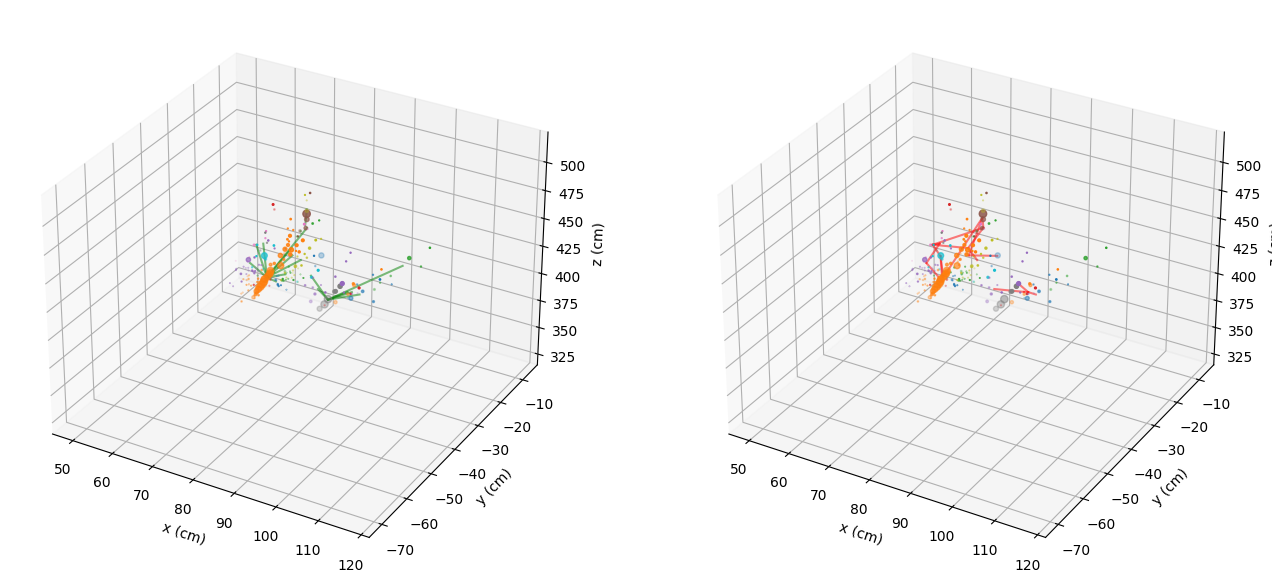

In [8]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
plot_tracksters(ax1, vx, vy, vz, ve)
plot_tracksters(ax2, vx, vy, vz, ve)
bary = get_bary(tracksters, eid)

def plot_edge(ax, edge, color):
    a, b = edge
    ca = bary[a]
    cb = bary[b]
    x = (ca[0], cb[0])
    y = (ca[1], cb[1])
    z = (ca[2], cb[2])
    ax.plot(x, y, z, c=color, alpha=0.5)

for edge in positive:
    plot_edge(ax1, edge, "green")

for edge in negative:
    plot_edge(ax2, edge, "red")

plt.show()

## Dataset

In [17]:
ds = TracksterPairs(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=10,
    balanced=False,
    include_neutral=False,
    MAX_DISTANCE=10,
    ENERGY_THRESHOLD=10
)
ds

<TracksterPairs len=95173 balanced=False max_distance=10 energy_threshold=10>

In [18]:
ds[0]

(tensor([-6.0912e+01, -5.1009e+01,  4.0108e+02,  2.2758e+00,  0.0000e+00,
          1.8858e+02,  6.2793e-12, -1.1011e-15, -1.5020e-01, -1.6981e-01,
          9.7396e-01,  1.3732e+01,  7.6211e-02,  8.3155e-02, -5.8280e+01,
         -4.0521e+01,  3.5484e+02,  2.5693e+02,  2.2756e+02,  2.0614e+02,
          3.8696e-01,  1.0493e-01, -1.5483e-01, -9.4787e-02,  9.8338e-01,
          1.3412e+01,  2.8138e+00,  4.3384e+00,  3.9503e+00,  2.0000e+00,
          5.5000e+01,  1.0000e+00,  1.9421e+01,  1.8949e+00,  1.0000e+00,
          0.0000e+00,  1.0000e+00,  3.8909e+00,  4.7933e+02,  3.8137e+02,
          7.2054e-02,  5.0365e-01,  6.0000e+00]),
 tensor(1.))

## Dummy evaluation

Let's talk baselines on this dataset. How good is a random guess?
How good is connecting to all nodes in a neighbourhood?

In [19]:
from reco.evaluation import pairwise_model_evaluation

In [20]:
class DummyModel:
    def eval(self):
        pass

class DummyPleaser(DummyModel):
    def __call__(self, X):
        return torch.tensor(np.ones(len(X)))

class DummyGuesser(DummyModel):
    def __call__(self, X):
        return torch.tensor(np.random.random(len(X)))

class DummyScaler:
    def transform(self, X):
        return X.tolist()

In [22]:
result = pairwise_model_evaluation(
    tracksters,
    simtracksters,
    associations,
    graph,
    DummyPleaser(),
    DummyScaler(),
    0.5,
    max_distance=20,
    energy_threshold=10,
    max_events=10,
    reco_to_target=False,
)

Event 0:
	clue3d_to_sim:	P: 0.99 R: 0.23 F: 0.27
	target_to_sim:	P: 0.99 R: 0.36 F: 0.41
	reco_to_target:	P: 0.82 R: 0.72 F: 0.73
	reco_to_sim:	P: 0.99 R: 0.39 F: 0.45
Event 1:
	clue3d_to_sim:	P: 1.00 R: 0.20 F: 0.24
	target_to_sim:	P: 1.00 R: 0.36 F: 0.41
	reco_to_target:	P: 0.88 R: 0.86 F: 0.87
	reco_to_sim:	P: 1.00 R: 0.39 F: 0.45
Event 2:
	clue3d_to_sim:	P: 0.96 R: 0.15 F: 0.18
	target_to_sim:	P: 0.96 R: 0.43 F: 0.49
	reco_to_target:	P: 0.62 R: 0.61 F: 0.61
	reco_to_sim:	P: 0.91 R: 0.51 F: 0.56
Event 3:
	clue3d_to_sim:	P: 1.00 R: 0.56 F: 0.61
	target_to_sim:	P: 1.00 R: 1.00 F: 1.00
	reco_to_target:	P: 1.00 R: 0.95 F: 0.96
	reco_to_sim:	P: 1.00 R: 0.95 F: 0.96
Event 4:
	clue3d_to_sim:	P: 1.00 R: 0.23 F: 0.27
	target_to_sim:	P: 1.00 R: 0.77 F: 0.80
	reco_to_target:	P: 0.81 R: 0.52 F: 0.56
	reco_to_sim:	P: 1.00 R: 0.42 F: 0.48
Event 5:
	clue3d_to_sim:	P: 1.00 R: 0.87 F: 0.90
	target_to_sim:	P: 1.00 R: 1.00 F: 1.00
	reco_to_target:	P: 1.00 R: 1.00 F: 1.00
	reco_to_sim:	P: 1.00 R: 1.00 